In [1]:
###Problem definition
#Anyone has Cardio Disease or not

###Data
#Dataset is loaded already

###Evaluation
#In this segment, 95% or more accuracy is required

In [2]:
#Importing libraries
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [3]:
#Loading Dataset
df = pd.read_csv("/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv")
#Exploratory Data Analysis
df.shape

(70000, 1)

In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts') 
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv


In [8]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# cardio_train.csv has 70000 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv', delimiter=';', nrows = nRowsRead)
df1.dataframeName = 'cardio_train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 13 columns


In [9]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
df1.tail(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
995,1381,19640,2,167,64.0,110,70,1,1,0,0,0,0
996,1383,18951,1,168,78.0,120,80,1,1,0,0,1,1
997,1385,18751,1,149,56.0,140,80,1,1,0,0,1,1
998,1386,17371,1,156,74.0,150,90,1,1,0,0,0,1
999,1387,20254,1,150,68.0,120,80,2,2,0,0,0,1


In [11]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [12]:
df1["active"].value_counts()

active
1    778
0    222
Name: count, dtype: int64

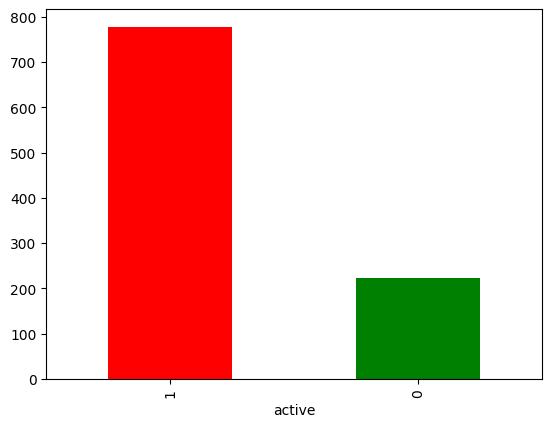

In [13]:
df1["active"].value_counts().plot(kind="bar",color=["red","green"]);

In [14]:
df1.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [15]:
df1.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,701.971000,19431.52100,1.359000,164.102000,74.734300,127.463000,92.655000,1.393000,1.241000,0.095000,0.04600,0.778000,0.507000
std,405.450658,2521.04067,0.479947,8.363704,15.259966,18.106918,102.072635,0.697881,0.589293,0.293362,0.20959,0.415799,0.500201
min,0.000000,14321.00000,1.000000,76.000000,41.000000,11.000000,30.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000
25%,343.750000,17509.50000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.00000,1.000000,0.000000
50%,717.000000,19666.00000,1.000000,164.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000
75%,1049.250000,21367.25000,2.000000,170.000000,84.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.00000,1.000000,1.000000
max,1387.000000,23661.00000,2.000000,188.000000,200.000000,200.000000,1100.000000,3.000000,3.000000,1.000000,1.00000,1.000000,1.000000


In [16]:
df1.gender.value_counts()

gender
1    641
2    359
Name: count, dtype: int64

In [17]:
len(df)

70000

In [18]:
pd.crosstab(df1.gender,df1.active)

active,0,1
gender,,
1,140,501
2,82,277


In [19]:
#How much female have heart disease
140/641 

0.21840873634945399

In [20]:
#How much male have heart disease 
277/359

0.7715877437325905

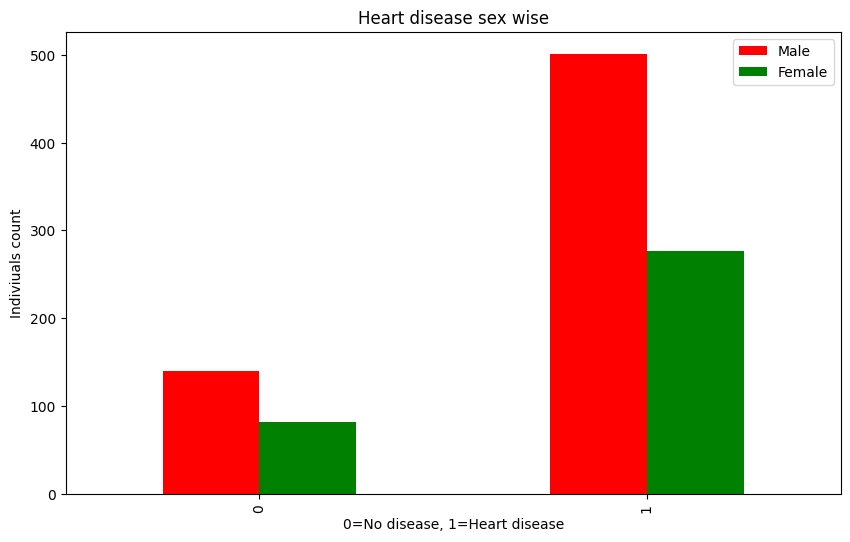

In [21]:
#Relationship between Gender who in munber are more heart patient 
pd.crosstab(df1.active,df1.gender).plot(kind="bar",
                                    figsize=(10,6),
                                    color=["red","green"])
plt.title("Heart disease sex wise")
plt.xlabel("0=No disease, 1=Heart disease")
plt.ylabel("Indiviuals count")
plt.legend(["Male", "Female"])

In [22]:
df1.ap_hi.value_counts

<bound method IndexOpsMixin.value_counts of 0      110
1      140
2      130
3      150
4      100
      ... 
995    110
996    120
997    140
998    150
999    120
Name: ap_hi, Length: 1000, dtype: int64>

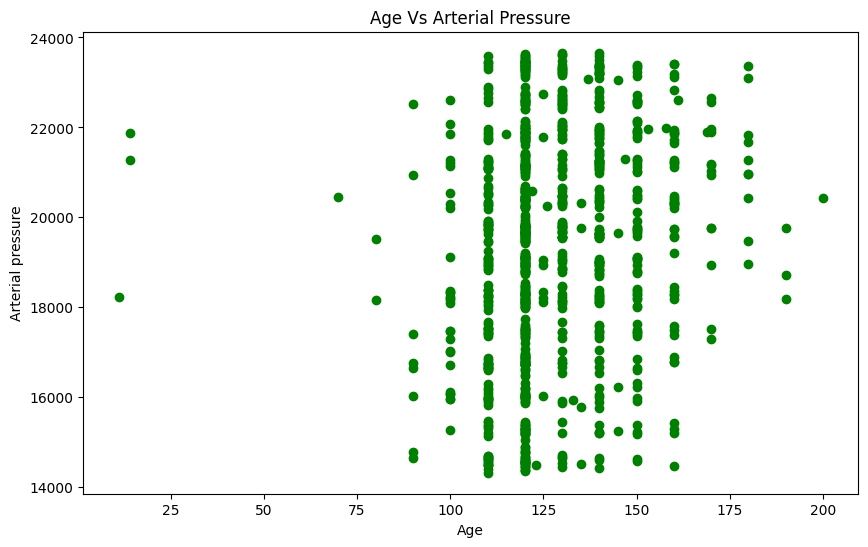

In [23]:
#Plotting relationship between Age and Arterial Pressure 
plt.figure(figsize = (10,6))
plt.scatter(df1.ap_hi, df1.age, c="Green")
plt.xlabel("Age")
plt.ylabel("Arterial pressure")
plt.title("Age Vs Arterial Pressure")
plt.show()

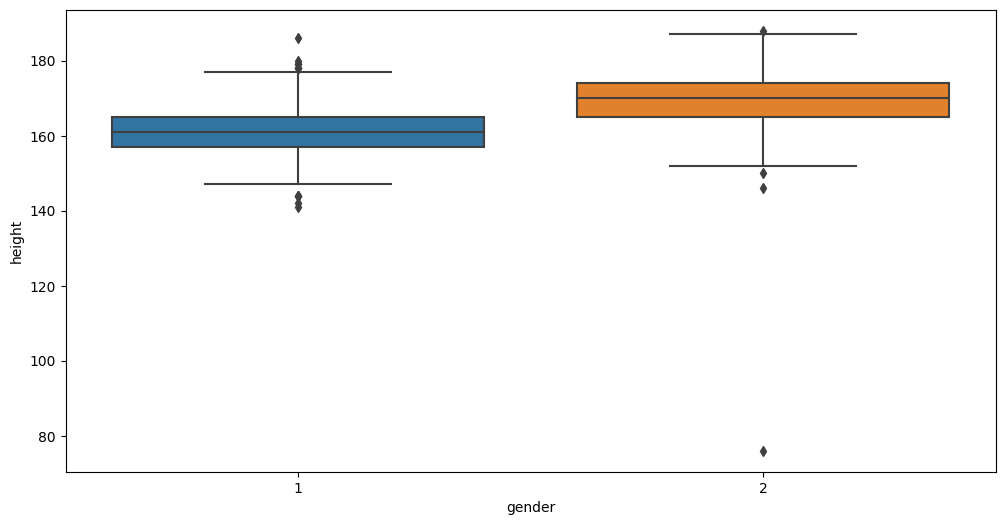

In [24]:
#Relationship between Gender and Height
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='height', data=df1)
plt.show()

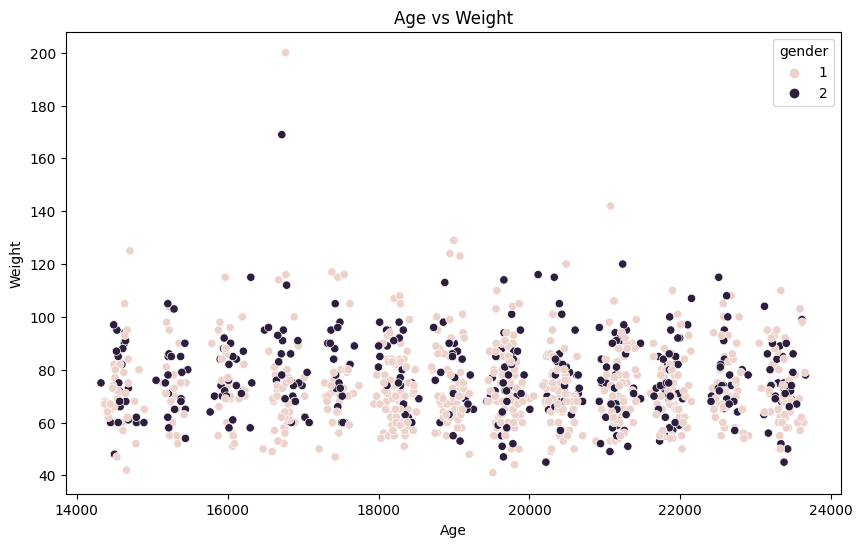

In [25]:
# Scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='weight', hue='gender', data=df1)
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age vs Weight')
plt.show()

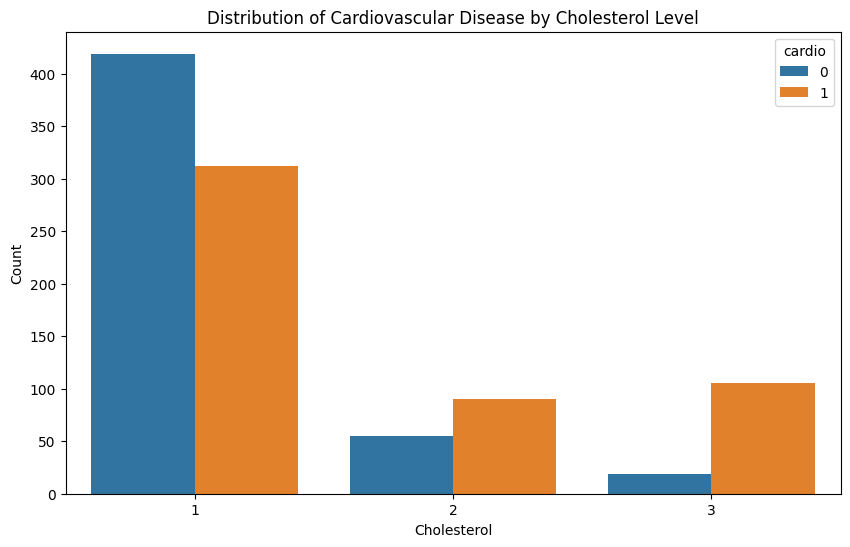

In [26]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='cholesterol', hue='cardio', data=df1)
plt.xlabel('Cholesterol')
plt.ylabel('Count')
plt.title('Distribution of Cardiovascular Disease by Cholesterol Level')
plt.show()

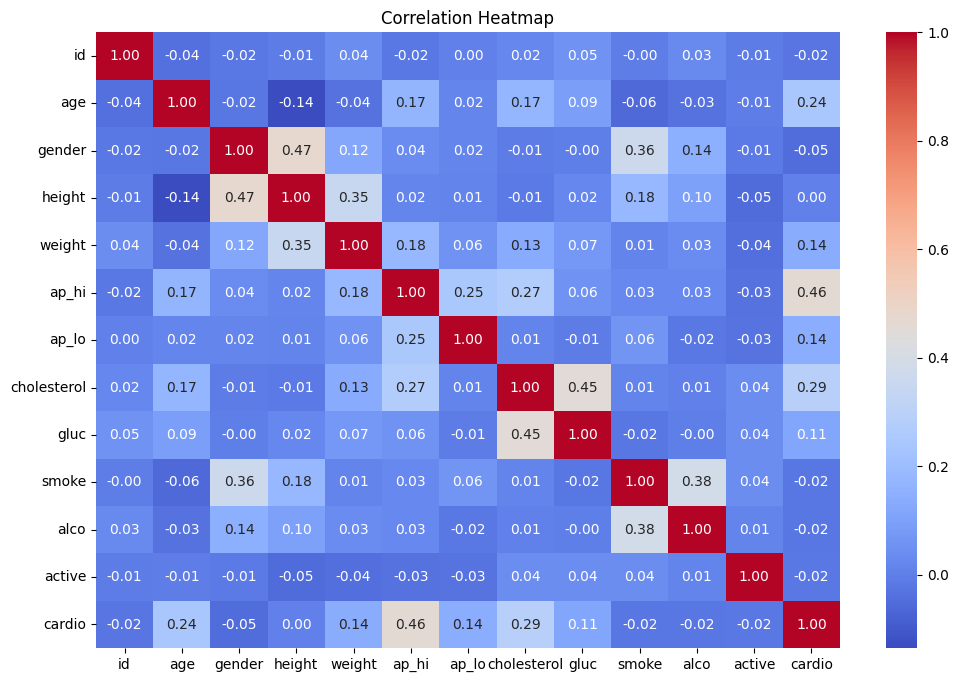

In [27]:
#Plotting Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

/tmp/ipykernel_18/3723928411.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['cholesterol'], shade=True, color='blue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


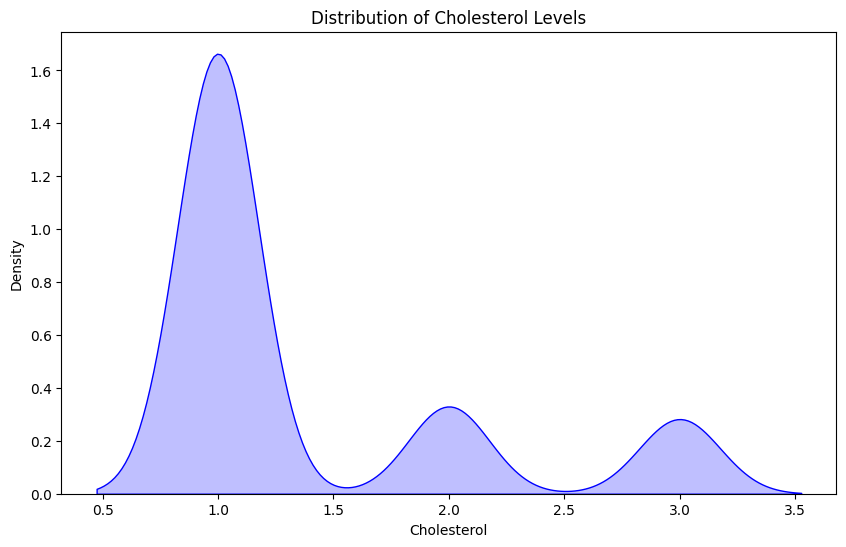

In [28]:
# Distribution Plot between Cholestrol and Density of it
plt.figure(figsize=(10, 6))
sns.kdeplot(df1['cholesterol'], shade=True, color='blue')
plt.xlabel('Cholesterol')
plt.ylabel('Density')
plt.title('Distribution of Cholesterol Levels')
plt.show()

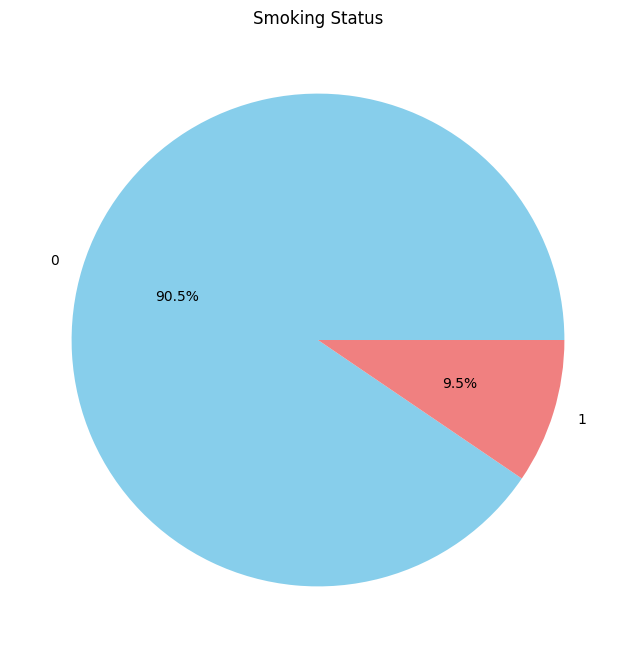

In [29]:
# Pie Chart
plt.figure(figsize=(8, 8))
df1['smoke'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Smoking Status')
plt.ylabel('')
plt.show()

/tmp/ipykernel_18/178273825.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['cholesterol'], shade=True, color='Orange')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


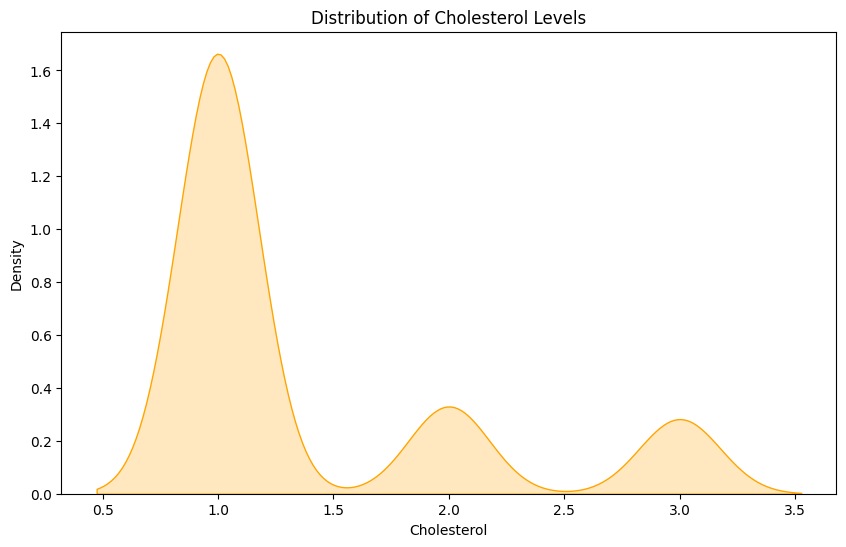

In [30]:
# KDE plot with fill
plt.figure(figsize=(10, 6))
sns.kdeplot(df1['cholesterol'], shade=True, color='Orange')
plt.xlabel('Cholesterol')
plt.ylabel('Density')
plt.title('Distribution of Cholesterol Levels')
plt.show()

The End

